In [49]:
import scipy.optimize as optimize
from scipy.stats import pearsonr
# will have 3 technical indicators: SMA/ExpMA, bollinger bandwidth, and price momentum
# will work with a new definition of NN, with 3 input neurons, 4 hidden neurons (one hidden layer), 
# and 1 output neuron, because it will take extra derivation steps to take into account more hidden layers 

# SKIPPING BACKPROPAGATION as it is deemed unneccesary for this type of neuro-genetic algorithm
import numpy as np
import scipy

X = np.matrix([[2,2,2],[3,4,4],[1,1,2]], dtype = float)
y = np.matrix([[10],[14],[7]], dtype = float)
# scale vars


X = X / np.max(X)
y = y / np.max(y)

In [2]:
class Neural_Network(object):
    def __init__(self, Lambda = 0):
        # the hyperparameters (do not change) go over here
        self.input_size = 3 # units in number of neurons
        self.hidden_size = 4
        self.output_size = 1 
        #------------------------------------------------------------------
        # initialize random weight definitions
        self.weight_1 = np.random.randn(self.input_size, self.hidden_size)
        self.weight_2 = np.random.randn(self.hidden_size, self.output_size)
        # regularization param
        self.Lambda = Lambda
        
    def forward_propagation(self, X): # exactly the same as welch's definition
        # h denotes values at the hidden layer
        # H denotes values of hidden layer after sigmoid activation
        # O denotes values at output layer
        # ans denotes value of output after sigmoid activation
        self.h = np.dot(X, self.weight_1)
        self.H = self.sigmoid(self.h)
        self.O = np.dot(self.H, self.weight_2)
        ans = self.sigmoid(self.O)
        return ans    
    
    def cost_function(self, X, y):
        ''' Very important function: finds cost of the forward_propagation'''
        self.ans = self.forward_propagation(X)
#         print(self.ans)
#         print(y)
        cost = 0.5*np.sum(np.square(y - self.ans))/X.shape[0] \
                        + (self.Lambda/2)*(np.sum(np.square(self.weight_1))+np.sum(np.square(self.weight_2)))
        return cost
    
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward_propagation(X)

        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.O))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.H.T, delta3)/X.shape[0] + self.Lambda*self.weight_2

        delta2 = np.dot(delta3, self.weight_2.T)*self.sigmoidPrime(self.h)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.weight_1
        return dJdW1, dJdW2

    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.weight_1.ravel(), self.weight_2.ravel()))
        return params

    def setParams(self, params):
        weight_1_start = 0
        weight_1_end = self.hidden_size * self.input_size
        self.weight_1 = np.reshape(params[weight_1_start:weight_1_end], \
                             (self.input_size, self.hidden_size))
        weight_2_end = weight_1_end + self.hidden_size*self.output_size
        self.weight_2 = np.reshape(params[weight_1_end:weight_2_end], \
                             (self.hidden_size, self.output_size))    
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
        
    # -----------------------------------------------------
    # Utility functions
    # -----------------------------------------------------
    def sigmoid(self, to_convert):
        return 1/(1+np.exp(-to_convert))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)

In [64]:
# defining the trainer class; it inherits the neural network.
class Trainer(object):
    def __init__(self, inherited_NN, X, y):
        '''inherits using the NN object, also delivers values of X and y to each instance 
        of the object.'''
        self.NN = inherited_NN
        self.X = X
        self.y = y
    
    def costFunctionWrapper(self, params):
        self.NN.setParams(params)
        cost = self.NN.cost_function(self.X, self.y)
        gradient = self.NN.computeGradients(self.X, self.y)
        return cost, gradient
    
    def train(self):        
        params0 = self.NN.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 options=options)

        self.NN.setParams(_res.x)
        self.optimizationResults = _res
        
#     def train(self):
#         # return struc res
#         bounds = [(-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), \
#                  (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5)]
#         res = scipy.optimize.differential_evolution(self.costFunctionWrapper, bounds, \
#                                                     polish = True, disp = False)
#         self.results = res        
#         self.NN.setParams(self.results.x)
        

In [65]:
import pandas as pd
import numpy as np

apple = symbols('AAPL')
data = get_pricing(apple, fields = 'close_price', start_date = '2014-12-30', end_date = '2016-01-31')

def find_SMA(pricing, window):
    df = pd.DataFrame()
    df['SMA'] = pricing.rolling(window=window,center=False).mean()
    df = df.dropna()
    return df['SMA']
    
def find_bolling_bandwidth(pricing, common_window):
    df = pd.DataFrame()
    df['SMA'] = find_SMA(pricing, common_window)
    df['STDev'] = pricing.rolling(window = common_window, center = False).std()
    upper_band = df['SMA'] + 2*df['STDev']; lower_band = df['SMA'] - 2*df['STDev']
    df['Bandwidth'] = ((upper_band - lower_band) / df['SMA']) * 100
    df = df.dropna()
    return df['Bandwidth']

def find_price_momentum(pricing, window):
    df = pd.DataFrame()
    df['close_price'] = pricing
    df['PM'] = pricing / pricing.shift(window)
    df = df.dropna()
    return df['PM']

def generate_vals_for_NN(pricing_data, common_lookback_window):
    master_df = pd.DataFrame()
    master_df['Price'] = pricing_data
    master_df['SMA'] = find_SMA(pricing_data, common_lookback_window)
    master_df['Bandwidth'] = find_bolling_bandwidth(pricing_data, common_lookback_window)
    master_df['PM'] = find_price_momentum(pricing_data, common_lookback_window)
    master_df = master_df.dropna()
    return master_df

vals = generate_vals_for_NN(data, 3)

In [67]:
y_new = vals.ix[:,0].values
y_new = np.reshape(y_new, (y_new.shape[0],1))
X_new = vals.ix[:, [1,2,3]].values


ymax = np.max(y_new)
X_new = X_new / np.max(X_new)
y_new = y_new / np.max(y_new)

print(y_new)
print(X_new)

[[ 0.79499277]
 [ 0.79484819]
 [ 0.80621718]
 [ 0.83704436]
 [ 0.83801842]
 [ 0.81751769]
 [ 0.82473937]
 [ 0.82155848]
 [ 0.79933795]
 [ 0.79297618]
 [ 0.81340081]
 [ 0.81968648]
 [ 0.84093296]
 [ 0.84542272]
 [ 0.84617609]
 [ 0.81669584]
 [ 0.86285671]
 [ 0.8896431 ]
 [ 0.87669888]
 [ 0.8875428 ]
 [ 0.88739822]
 [ 0.89450575]
 [ 0.90089795]
 [ 0.89323491]
 [ 0.89931512]
 [ 0.91659691]
 [ 0.9379271 ]
 [ 0.94972224]
 [ 0.95460772]
 [ 0.96008675]
 [ 0.96692033]
 [ 0.96497222]
 [ 0.97277985]
 [ 0.99907161]
 [ 0.9929153 ]
 [ 0.96737691]
 [ 0.97962103]
 [ 0.96504832]
 [ 0.9696294 ]
 [ 0.9718819 ]
 [ 0.96571798]
 [ 0.94949395]
 [ 0.95092459]
 [ 0.9548284 ]
 [ 0.93537022]
 [ 0.91832433]
 [ 0.93476904]
 [ 0.92838445]
 [ 0.93852827]
 [ 0.95453162]
 [ 0.96504832]
 [ 0.95768206]
 [ 0.94648809]
 [ 0.95558177]
 [ 0.95167795]
 [ 0.92688532]
 [ 0.93334602]
 [ 0.92575907]
 [ 0.94896888]
 [ 0.93484514]
 [ 0.93319382]
 [ 0.94130584]
 [ 0.95655582]
 [ 0.94652614]
 [ 0.94348984]
 [ 0.95069629]
 [ 0.95475

In [104]:
NN = Neural_Network(Lambda = 0.000025)
t = Trainer(NN, X_new, y_new)
t.train()


t.NN.weight_1, t.NN.weight_2

Optimization terminated successfully.
         Current function value: 0.001668
         Iterations: 98
         Function evaluations: 104
         Gradient evaluations: 104


(array([[ 1.38637942, -1.40465108, -1.44296169,  1.37633363],
        [-0.64815542,  1.42771661,  1.07800312, -1.04276388],
        [-0.0275299 ,  0.06418793,  0.03725378, -0.04299005]]),
 array([[ 2.36396118],
        [-3.72594827],
        [-3.51231863],
        [ 2.46300345]]))

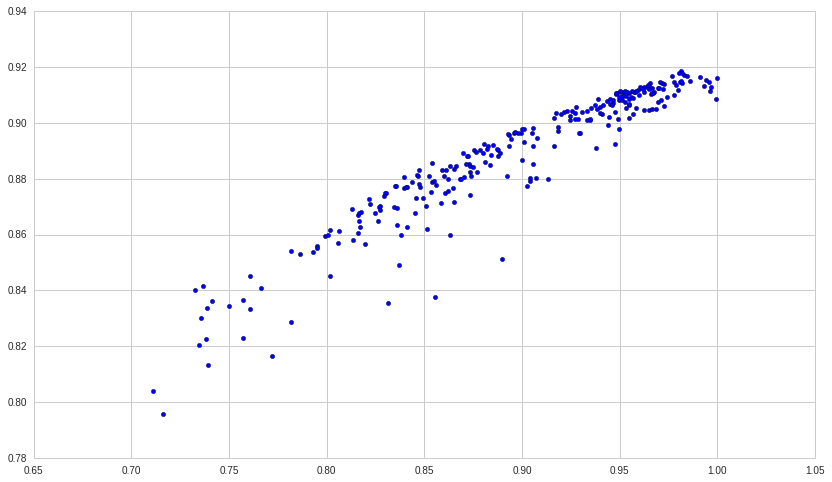

The correlation is 94.9210316509 %!


In [105]:
import matplotlib.pyplot as plt

y_new_predict = t.NN.forward_propagation(X_new)

plt.scatter(y_new, y_new_predict)
correl_stats = pearsonr(y_new, y_new_predict)
plt.show()

print('The correlation is {} %!'.format(str(float(correl_stats[0]*100))))

(270,)
(270, 1)
(270, 1)


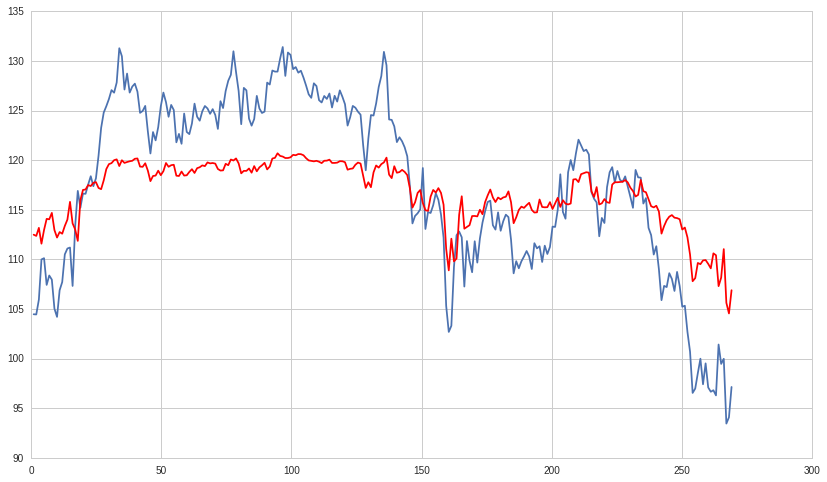

In [106]:
# we have matplot lib installed
# so we may plot the prices on one graph
x_axis = np.linspace(1, (len(y_new) - 1), len(y_new))

print(x_axis.shape)
print(y_new.shape)
print(y_new_predict.shape)
plt.plot(x_axis, y_new*ymax)
plt.plot(x_axis, y_new_predict*ymax, 'r')
plt.show()


Optimization terminated successfully.
         Current function value: 0.000312
         Iterations: 162
         Function evaluations: 185
         Gradient evaluations: 185


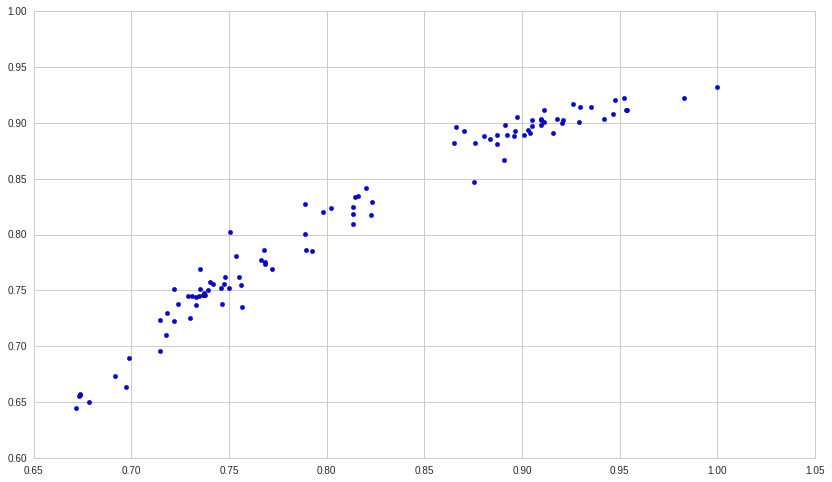

The correlation is 97.4920139452 %!


In [187]:
tsla = symbols('TSLA')
data_tsla = get_pricing(tsla, fields = 'close_price', start_date = '2016-12-31', end_date = '2017-08-10')

y_train = data[0:103]
y_test = data[103:len(data.values)]

train_vals = generate_vals_for_NN(y_train, 3)

train_y_new = train_vals.ix[:,0].values
train_y_new = np.reshape(train_y_new, (train_y_new.shape[0],1))
train_X_new = train_vals.ix[:, [1,2,3]].values

train_ymax = np.max(train_y_new)
train_X_new = train_X_new / np.max(train_X_new)
train_y_new = train_y_new / np.max(train_y_new)

######## Training model ########
NN = Neural_Network(Lambda = 0.000001)
t = Trainer(NN, train_X_new, train_y_new)
t.train()
######## Plotting predict vs expected and printing correlation ########
y_new_predict = t.NN.forward_propagation(train_X_new)
plt.scatter(train_y_new, y_new_predict)
correl_stats = pearsonr(train_y_new, y_new_predict)
plt.show()
print('The correlation is {} %!'.format(str(float(correl_stats[0]*100))))

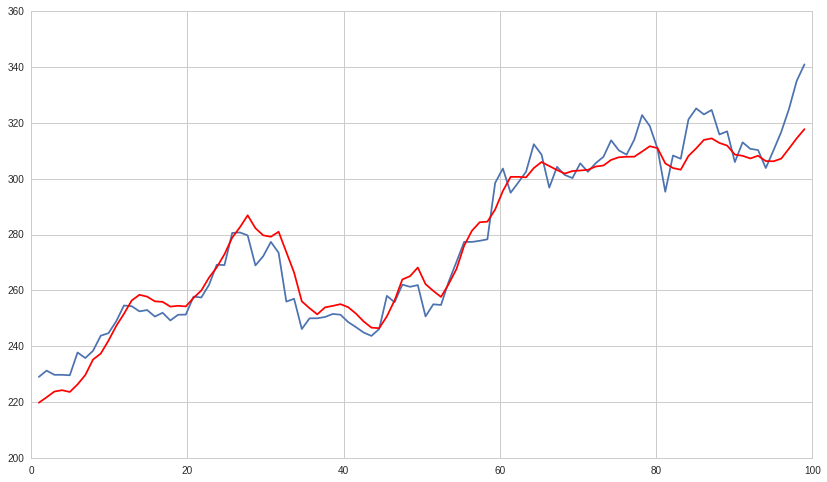

In [188]:
# VISUALIZING THE RELATIONSHIP FOR THE TEST BATCH
x_axis = np.linspace(1, (len(train_y_new) - 1), len(train_y_new))

plt.plot(x_axis, train_y_new * train_ymax)
plt.plot(x_axis, y_new_predict * train_ymax, 'r')
plt.show()

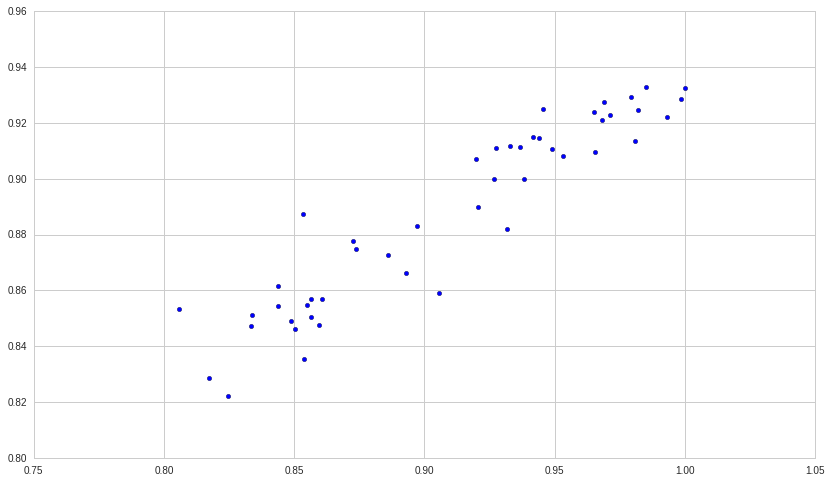

The correlation is 93.9575390052 %!


In [189]:
test_vals = generate_vals_for_NN(y_test, 3)

test_y_new = test_vals.ix[:,0].values
test_y_new = np.reshape(test_y_new, (test_y_new.shape[0],1))
test_X_new = test_vals.ix[:, [1,2,3]].values

test_ymax = np.max(test_y_new)
test_X_new = test_X_new / np.max(test_X_new)
test_y_new = test_y_new / np.max(test_y_new)

# NO NEED TO TRAIN, SINCE THIS IS THE TESTING DATASET

######## Plotting predict vs expected and printing correlation ########
y_new_predict_test = t.NN.forward_propagation(test_X_new)
plt.scatter(test_y_new, y_new_predict_test)
correl_stats = pearsonr(test_y_new, y_new_predict_test)
plt.show()
print('The correlation is {} %!'.format(str(float(correl_stats[0]*100))))

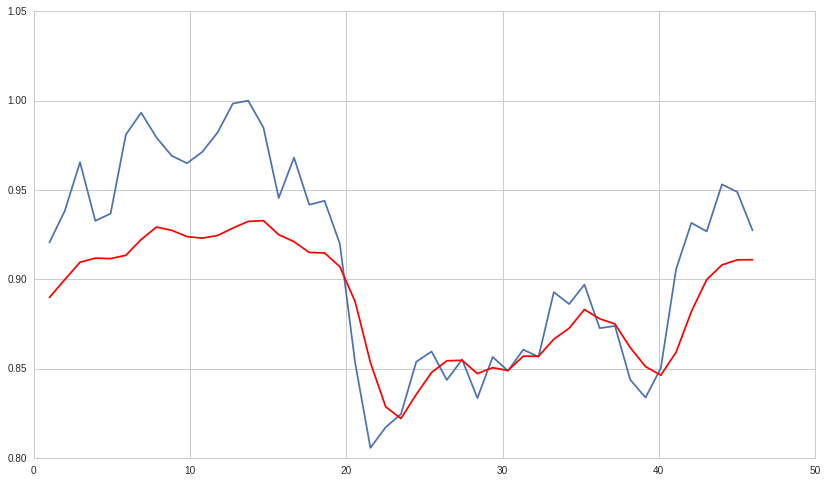

In [191]:
# VISUALIZING THE RELATIONSHIP FOR THE TEST BATCH
x_axis = np.linspace(1, (len(test_y_new) - 1), len(test_y_new))

plt.plot(x_axis, test_y_new)
plt.plot(x_axis, y_new_predict_test, 'r')
plt.show()

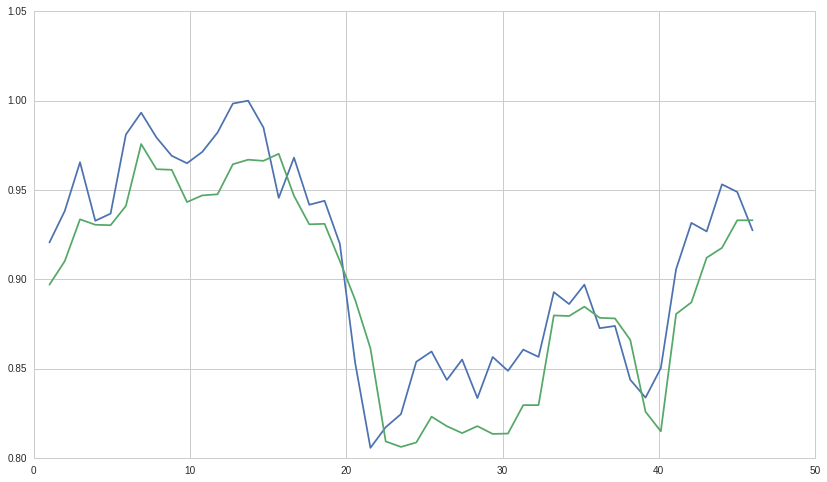

In [192]:
from sklearn.neighbors import KNeighborsRegressor # we can check the version of this module using
# print(sklearn.__version__) this will, in this case, return 0.16.1
KNN = KNeighborsRegressor(n_neighbors = 5, weights = 'distance')
# assign X and y. Let's just use X from the previous examples train_data, which was...
X = train_X_new 
y = train_y_new
KNN.fit(X, y)
# We can predict using the class.predict function. This requires an argument that is the SAME 
# in dimension as the train data. 

# hence we find a clever way to graph the test data
KNN_prediction = KNN.predict(test_X_new)

x_axis_KNN = np.linspace(1, (len(test_y_new) - 1), len(test_y_new))
plt.plot(x_axis_KNN, test_y_new)
plt.plot(x_axis_KNN, KNN_prediction)

In [208]:
if(y_new_predict_test.shape == KNN_prediction.shape):
    concat = np.concatenate((y_new_predict_test, KNN_prediction), axis = 1)
    ENSEMBLE_PREDICTION_MASTER = np.average(concat, axis = 1)

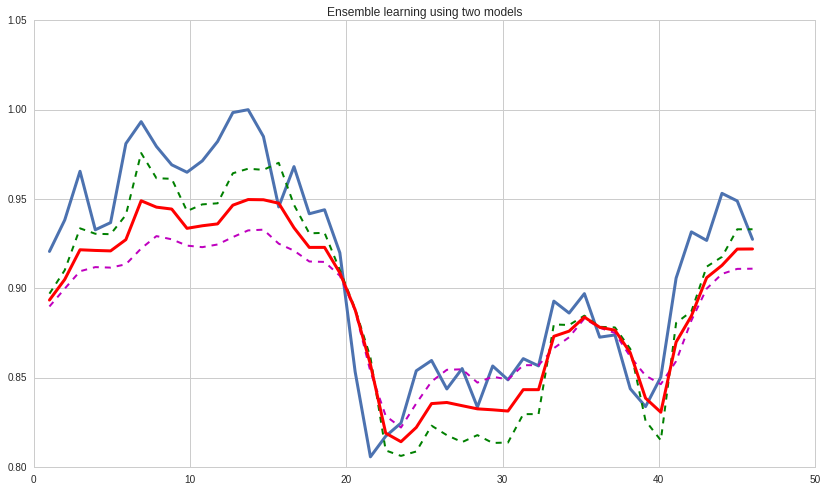

The correlation is 93.9755675147 %!


In [241]:
###### FINAL PLOTTING OF DATA ######
# we can just use the same old x_axis, lying around from previous cells
plt.plot(x_axis, test_y_new, linewidth = 3)
plt.plot(x_axis, y_new_predict_test, 'm--', linewidth = 2)
plt.plot(x_axis, KNN_prediction, 'g--', linewidth = 2)
plt.plot(x_axis, ENSEMBLE_PREDICTION_MASTER, 'r' ,linewidth = 3)
plt.title('Ensemble learning using two models')
plt.show()


ENSEMBLE_PREDICTION_MASTER = np.reshape(ENSEMBLE_PREDICTION_MASTER, (ENSEMBLE_PREDICTION_MASTER.shape[0],1))
correl_stats = pearsonr(test_y_new, ENSEMBLE_PREDICTION_MASTER)
print('The correlation is {} %!'.format(str(float(correl_stats[0]*100))))

### Thank you

Thank you for going through this notebook. I hope this was of value to you!
**- Naman Pujari**